# Postprocessing

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
#%load_ext line_profiler
#%load_ext snakeviz
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import corner

import pickle

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import deterministic

from scipy.stats import norm

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import glob
import json
import h5py
import healpy as hp
import scipy.constants as sc
import emcee

from numba.typed import List

import sys
import h5py

In [2]:
#load psr pickles

#make sure this points to the same pickled pulsars we used for the MCMC
data_pkl = '/scratch/na00078/15yr_data/15yrCW/v1p1_de440_pint_bipm2019_unshifted_pdist.pkl'

#with open('nanograv_11yr_psrs_old.pkl', 'rb') as psr_pkl:
with open(data_pkl, 'rb') as psr_pkl:
    psrs = pickle.load(psr_pkl)
    
print(len(psrs))

67


In [3]:
#load psr names only if we want to save RAM
class psr_name:
    def __init__(self, name):
        self.name = name

psrListFile = "/scratch/na00078/15yr_data/15yr_v1_1/psrlist_15yr_pint.txt"

psrs = []
with open(psrListFile, 'r') as fff:
    for line in fff:
        psrname = line.strip()
        #print(psrname)
        psrs.append(psr_name(psrname))
        
print(len(psrs))
for i,psr in enumerate(psrs):
    print(str(i) + ": " + psr.name)

67
0: B1855+09
1: B1937+21
2: B1953+29
3: J0023+0923
4: J0030+0451
5: J0340+4130
6: J0406+3039
7: J0437-4715
8: J0509+0856
9: J0557+1551
10: J0605+3757
11: J0610-2100
12: J0613-0200
13: J0636+5128
14: J0645+5158
15: J0709+0458
16: J0740+6620
17: J0931-1902
18: J1012+5307
19: J1012-4235
20: J1022+1001
21: J1024-0719
22: J1125+7819
23: J1312+0051
24: J1453+1902
25: J1455-3330
26: J1600-3053
27: J1614-2230
28: J1630+3734
29: J1640+2224
30: J1643-1224
31: J1705-1903
32: J1713+0747
33: J1719-1438
34: J1730-2304
35: J1738+0333
36: J1741+1351
37: J1744-1134
38: J1745+1017
39: J1747-4036
40: J1751-2857
41: J1802-2124
42: J1811-2405
43: J1832-0836
44: J1843-1113
45: J1853+1303
46: J1903+0327
47: J1909-3744
48: J1910+1256
49: J1911+1347
50: J1918-0642
51: J1923+2515
52: J1944+0907
53: J1946+3417
54: J2010-1323
55: J2017+0603
56: J2033+1734
57: J2043+1711
58: J2124-3358
59: J2145-0750
60: J2214+3000
61: J2229+2643
62: J2234+0611
63: J2234+0944
64: J2302+4442
65: J2317+1439
66: J2322+2057


## Load run + general diagnostics

In [4]:
pwd

'/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts'

In [5]:
# fileList = np.loadtxt('./results/HS1630_1bill_targeted_detect/THIN/THIN_List.txt', dtype = 'str') #list of all files in data set

# extra_thin = 25
# #empty arrays to hold all data via appending
# samples_cold = np.empty([1,8])
# log_likelihood = np.empty([1,1])
# par_names = []
# acc_fraction = np.empty([1,4])
# fisher_diag = np.empty([4,1])

# #loop through each file to append their data to the appropriate parts
# for i in fileList:
#     hdf_file = i
#     print(hdf_file)
#     with h5py.File(hdf_file, 'r') as f:
#         print(list(f.keys()))
#         #samples_cold= np.vstack((samples_cold, f['samples_cold'][0,::10,:]))
#         samples_cold = np.vstack((samples_cold, f['samples_cold'][0,::extra_thin,:]))
#         print(f['samples_cold'].dtype)
#         #samples = f['samples_cold'][...]
#         #log_likelihood = f['log_likelihood'][:,::10]
#         #print(f['log_likelihood'].dtype)
#         log_likelihood= np.hstack((log_likelihood, f['log_likelihood'][...]))
#         par_names=np.array([x.decode('UTF-8') for x in list(f['par_names'])])
#         acc_fraction = np.vstack( (acc_fraction, f['acc_fraction'][...]))
#         fisher_diag=np.hstack((fisher_diag,f['fisher_diag'][...]))

In [6]:
'''
#COMMENT IF OUTFILE GENERATED
#Thinning script for one source
i = "/scratch/na00078/QuickCW_targeted_runs/results/NGC3115_UL.h5"

infile = i
first_n_param = 8
outfile = '/scratch/na00078/QuickCW_targeted_runs/results/NGC3115_UL_thin10.h5'
thin = 10

print(infile)
print(first_n_param)
print(outfile)

with h5py.File(infile, 'r') as f:
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:]
    print("Infile sample shape", samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print("Infile loglikelihood shape", log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

with h5py.File(outfile, 'w') as f:
    f.create_dataset('samples_cold', data=samples_cold[:,:,:first_n_param], compression="gzip", chunks=True)
    f.create_dataset('log_likelihood', data=log_likelihood[:,:], compression="gzip", chunks=True)
    f.create_dataset('par_names', data=np.array(par_names, dtype='S'))
    f.create_dataset('acc_fraction', data=acc_fraction)
    f.create_dataset('fisher_diag', data=fisher_diag)
    f.create_dataset('T-ladder', data=Ts)

###################################################

with h5py.File(i, 'r') as f:
    print(list(f.keys()))
    samples_cold = f['samples_cold'][0,::10,:]
    print(f['samples_cold'].dtype)
    #samples = f['samples_cold'][...]
    #log_likelihood = f['log_likelihood'][:,::10]
    print(f['log_likelihood'].dtype)
    log_likelihood = f['log_likelihood'][...]
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

#print(acc_fraction)
#print(acc_fraction[:,:])
#print(samples.shape)
#samples_cold = np.copy(samples[0,:,::])
print(samples_cold.shape)
#print(par_names)

'''

'\n#COMMENT IF OUTFILE GENERATED\n#Thinning script for one source\ni = "/scratch/na00078/QuickCW_targeted_runs/results/NGC3115_UL.h5"\n\ninfile = i\nfirst_n_param = 8\noutfile = \'/scratch/na00078/QuickCW_targeted_runs/results/NGC3115_UL_thin10.h5\'\nthin = 10\n\nprint(infile)\nprint(first_n_param)\nprint(outfile)\n\nwith h5py.File(infile, \'r\') as f:\n    Ts = f[\'T-ladder\'][...]\n    samples_cold = f[\'samples_cold\'][:,:,:]\n    print("Infile sample shape", samples_cold[-1].shape)\n    log_likelihood = f[\'log_likelihood\'][:1,:]\n    print("Infile loglikelihood shape", log_likelihood.shape)\n    par_names = [x.decode(\'UTF-8\') for x in list(f[\'par_names\'])]\n    acc_fraction = f[\'acc_fraction\'][...]\n    fisher_diag = f[\'fisher_diag\'][...]\n\nwith h5py.File(outfile, \'w\') as f:\n    f.create_dataset(\'samples_cold\', data=samples_cold[:,:,:first_n_param], compression="gzip", chunks=True)\n    f.create_dataset(\'log_likelihood\', data=log_likelihood[:,:], compression="gzip

In [7]:
'''
#Thinning script for multiple sources

fileList = np.loadtxt('./results/3c66B_1bill_targeted_detect/3c66b_toThin.txt', dtype = 'str') #list of all files in data set
print(fileList) #Add names of h5 files to be thinned to txt file

for i in fileList:
    infile = i
    first_n_param = 8
    outfile = './results/3c66B_1bill_targeted_detect/THIN/thinned_'+i.split('/')[3]
    thin = 500
    
    print(infile)
    print(first_n_param)
    print(outfile)
    
    with h5py.File(infile, 'r') as f:
        Ts = f['T-ladder'][...]
        samples_cold = f['samples_cold'][:,:,:]
        print(samples_cold[-1].shape)
        log_likelihood = f['log_likelihood'][:1,:]
        print(log_likelihood.shape)
        par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
        acc_fraction = f['acc_fraction'][...]
        fisher_diag = f['fisher_diag'][...]
    
    with h5py.File(outfile, 'w') as f:
        f.create_dataset('samples_cold', data=samples_cold[:,::thin,:first_n_param], compression="gzip", chunks=True)
        f.create_dataset('log_likelihood', data=log_likelihood[:,:], compression="gzip", chunks=True)
        f.create_dataset('par_names', data=np.array(par_names, dtype='S'))
        f.create_dataset('acc_fraction', data=acc_fraction)
        f.create_dataset('fisher_diag', data=fisher_diag)
        f.create_dataset('T-ladder', data=Ts)


# i='./results/HS1630_1bill_targeted_detect/MassPriorChange/quickCW_15yr_HS1630+2355_1bill_targeteddetectNone.h5'
# infile = i
# first_n_param = 8
# outfile = './results/HS1630_1bill_targeted_detect/MassPriorChange/THIN/thin'+i.split('/')[4]

# print(infile)
# print(first_n_param)
# print(outfile)

# with h5py.File(infile, 'r') as f:
#     Ts = f['T-ladder'][...]
#     samples_cold = f['samples_cold'][:,:,:]
#     print(samples_cold[-1].shape)
#     log_likelihood = f['log_likelihood'][:1,:]
#     print(log_likelihood.shape)
#     par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
#     acc_fraction = f['acc_fraction'][...]
#     fisher_diag = f['fisher_diag'][...]

# with h5py.File(outfile, 'w') as f:
#     f.create_dataset('samples_cold', data=samples_cold[:,::thin,:first_n_param], compression="gzip", chunks=True)
#     f.create_dataset('log_likelihood', data=log_likelihood[:,:], compression="gzip", chunks=True)
#     f.create_dataset('par_names', data=np.array(par_names, dtype='S'))
#     f.create_dataset('acc_fraction', data=acc_fraction)
#     f.create_dataset('fisher_diag', data=fisher_diag)
#     f.create_dataset('T-ladder', data=Ts)

'''

'\n#Thinning script for multiple sources\n\nfileList = np.loadtxt(\'./results/3c66B_1bill_targeted_detect/3c66b_toThin.txt\', dtype = \'str\') #list of all files in data set\nprint(fileList) #Add names of h5 files to be thinned to txt file\n\nfor i in fileList:\n    infile = i\n    first_n_param = 8\n    outfile = \'./results/3c66B_1bill_targeted_detect/THIN/thinned_\'+i.split(\'/\')[3]\n    thin = 500\n    \n    print(infile)\n    print(first_n_param)\n    print(outfile)\n    \n    with h5py.File(infile, \'r\') as f:\n        Ts = f[\'T-ladder\'][...]\n        samples_cold = f[\'samples_cold\'][:,:,:]\n        print(samples_cold[-1].shape)\n        log_likelihood = f[\'log_likelihood\'][:1,:]\n        print(log_likelihood.shape)\n        par_names = [x.decode(\'UTF-8\') for x in list(f[\'par_names\'])]\n        acc_fraction = f[\'acc_fraction\'][...]\n        fisher_diag = f[\'fisher_diag\'][...]\n    \n    with h5py.File(outfile, \'w\') as f:\n        f.create_dataset(\'samples_cold\

In [8]:

with h5py.File('/scratch/na00078/QuickCW_targeted_runs/results/NGC3115_UL_thin10.h5', 'r') as f:
    print(list(f.keys()))
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:]
    print(samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print(log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

['T-ladder', 'acc_fraction', 'fisher_diag', 'log_likelihood', 'par_names', 'samples_cold']
(100000000, 8)
(1, 100000000)


Text(0, 0.5, 'Acceptance rate')

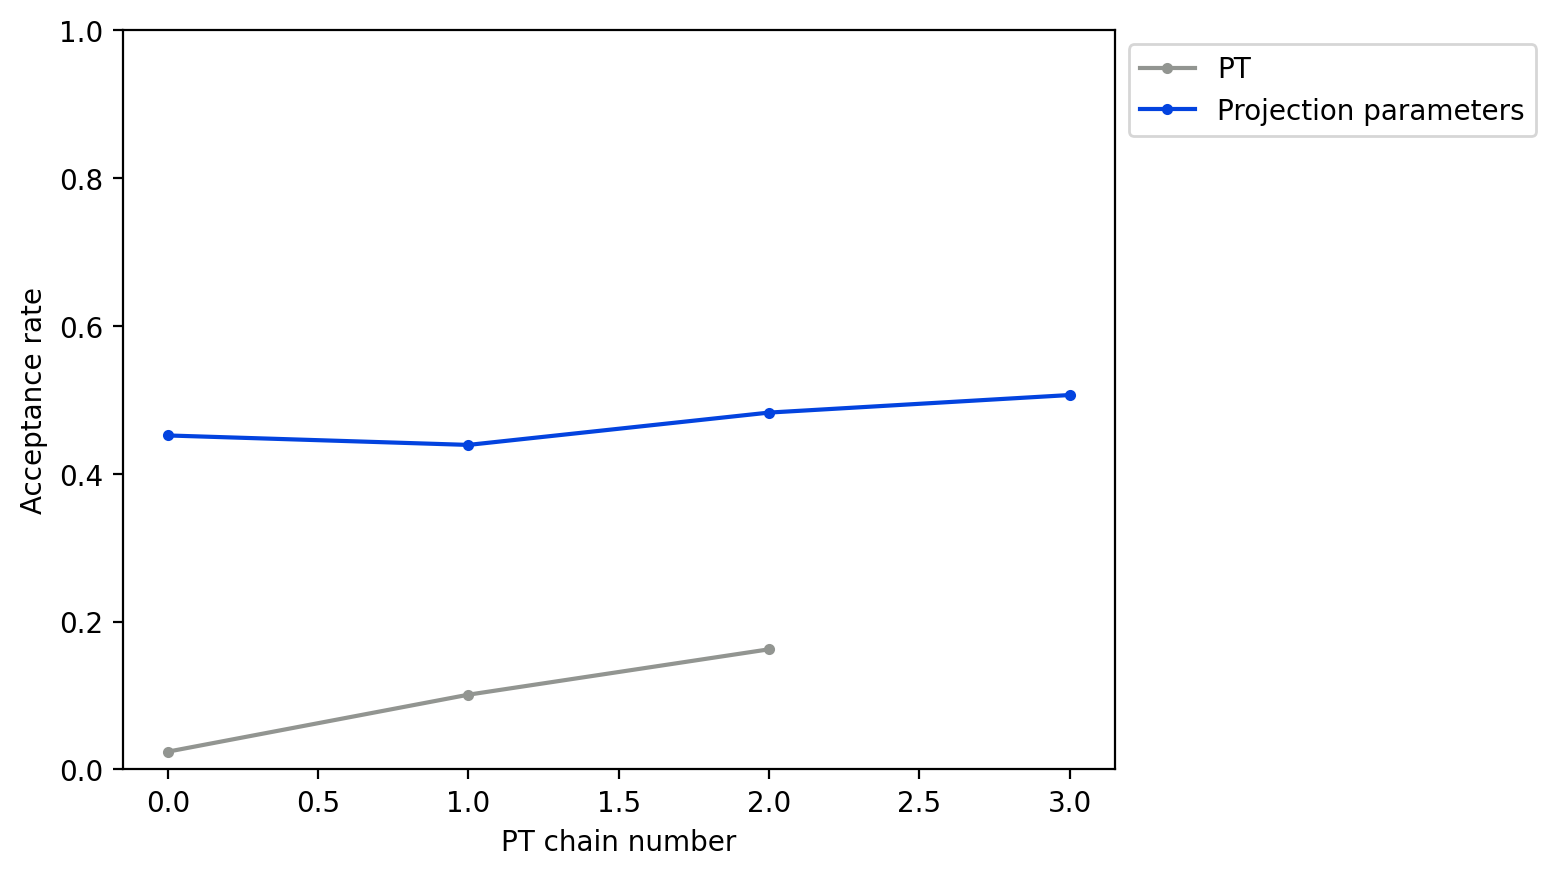

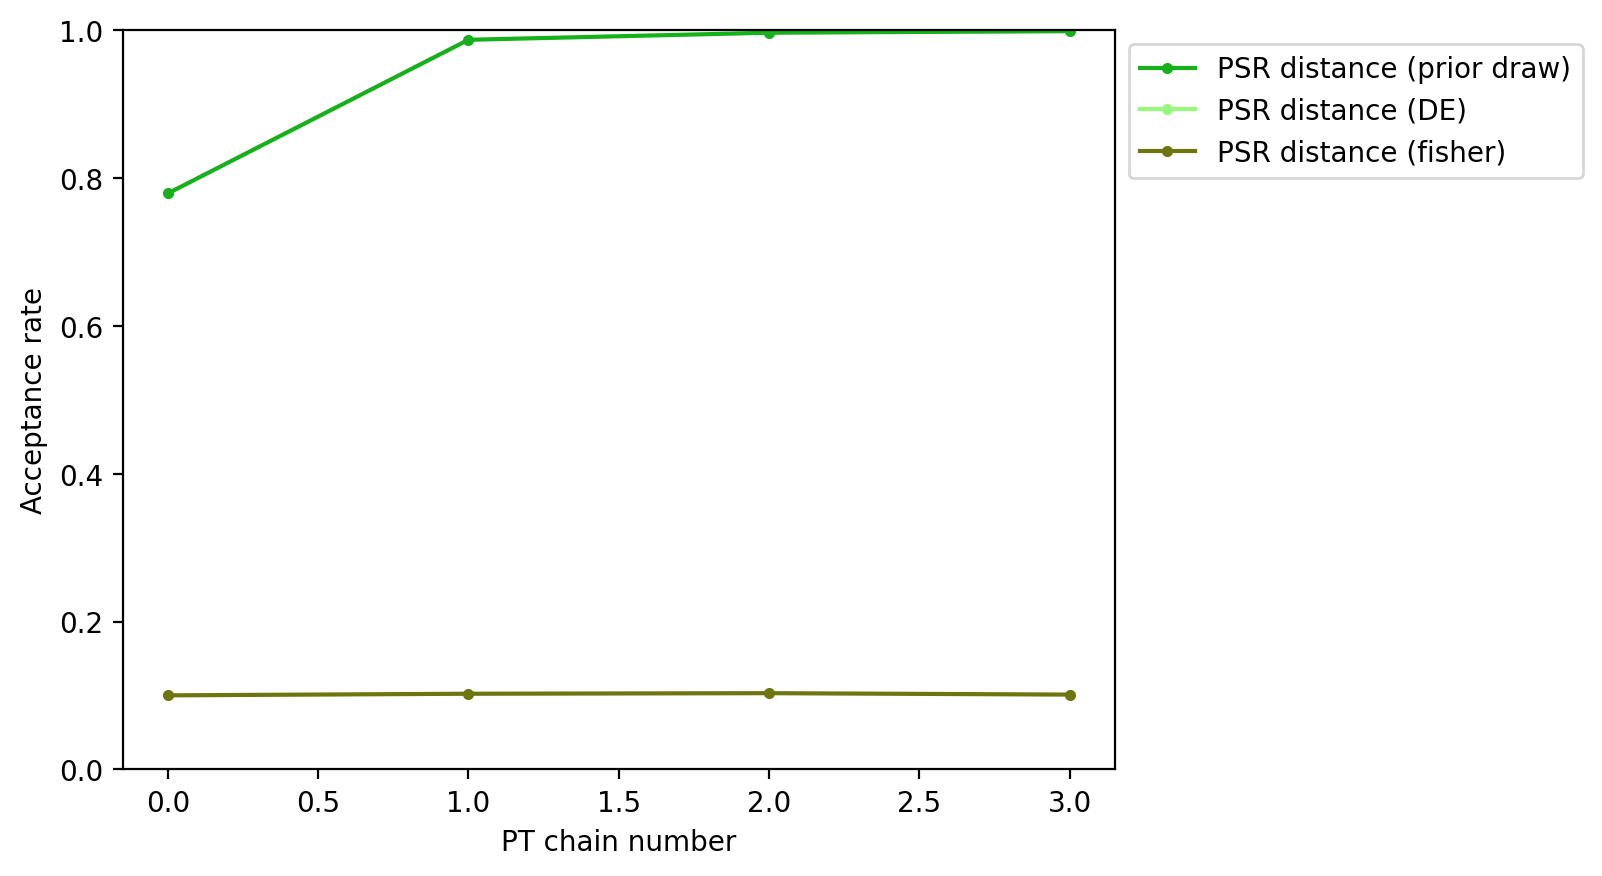

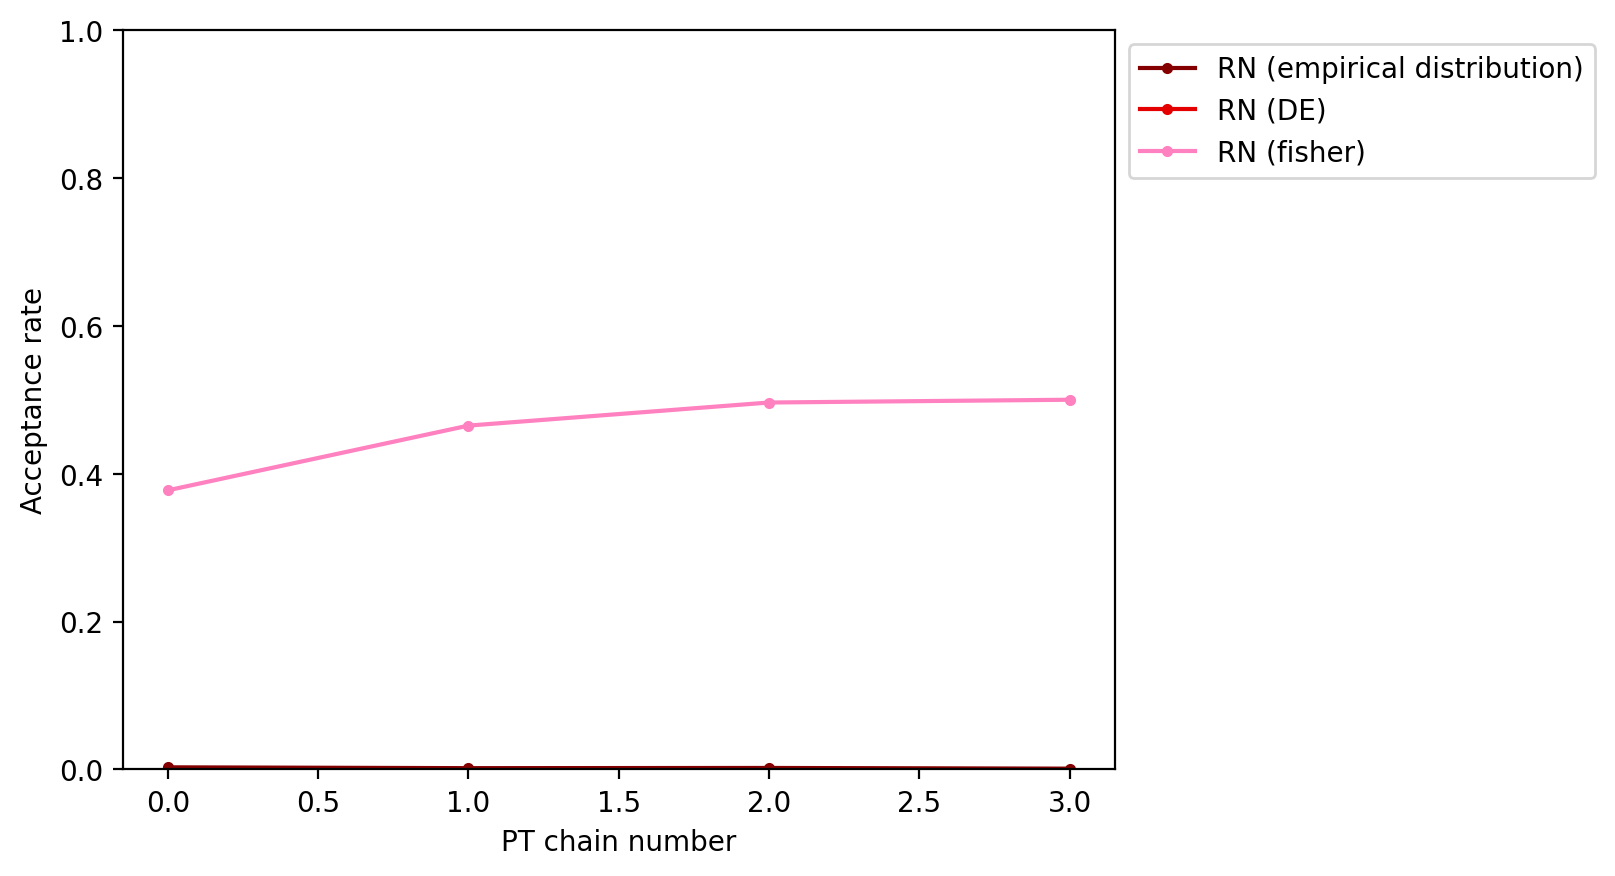

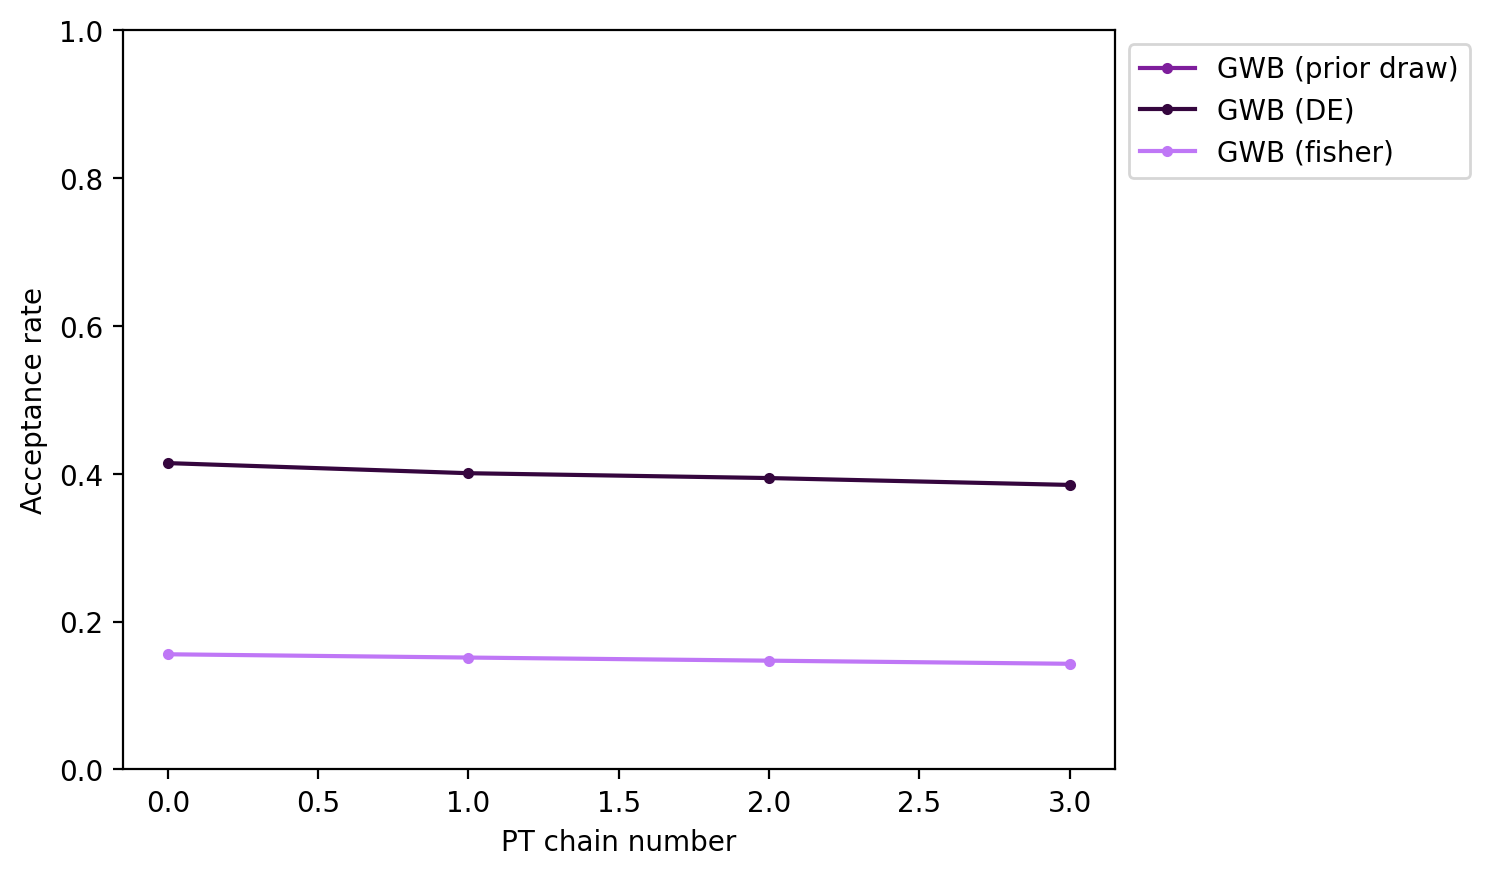

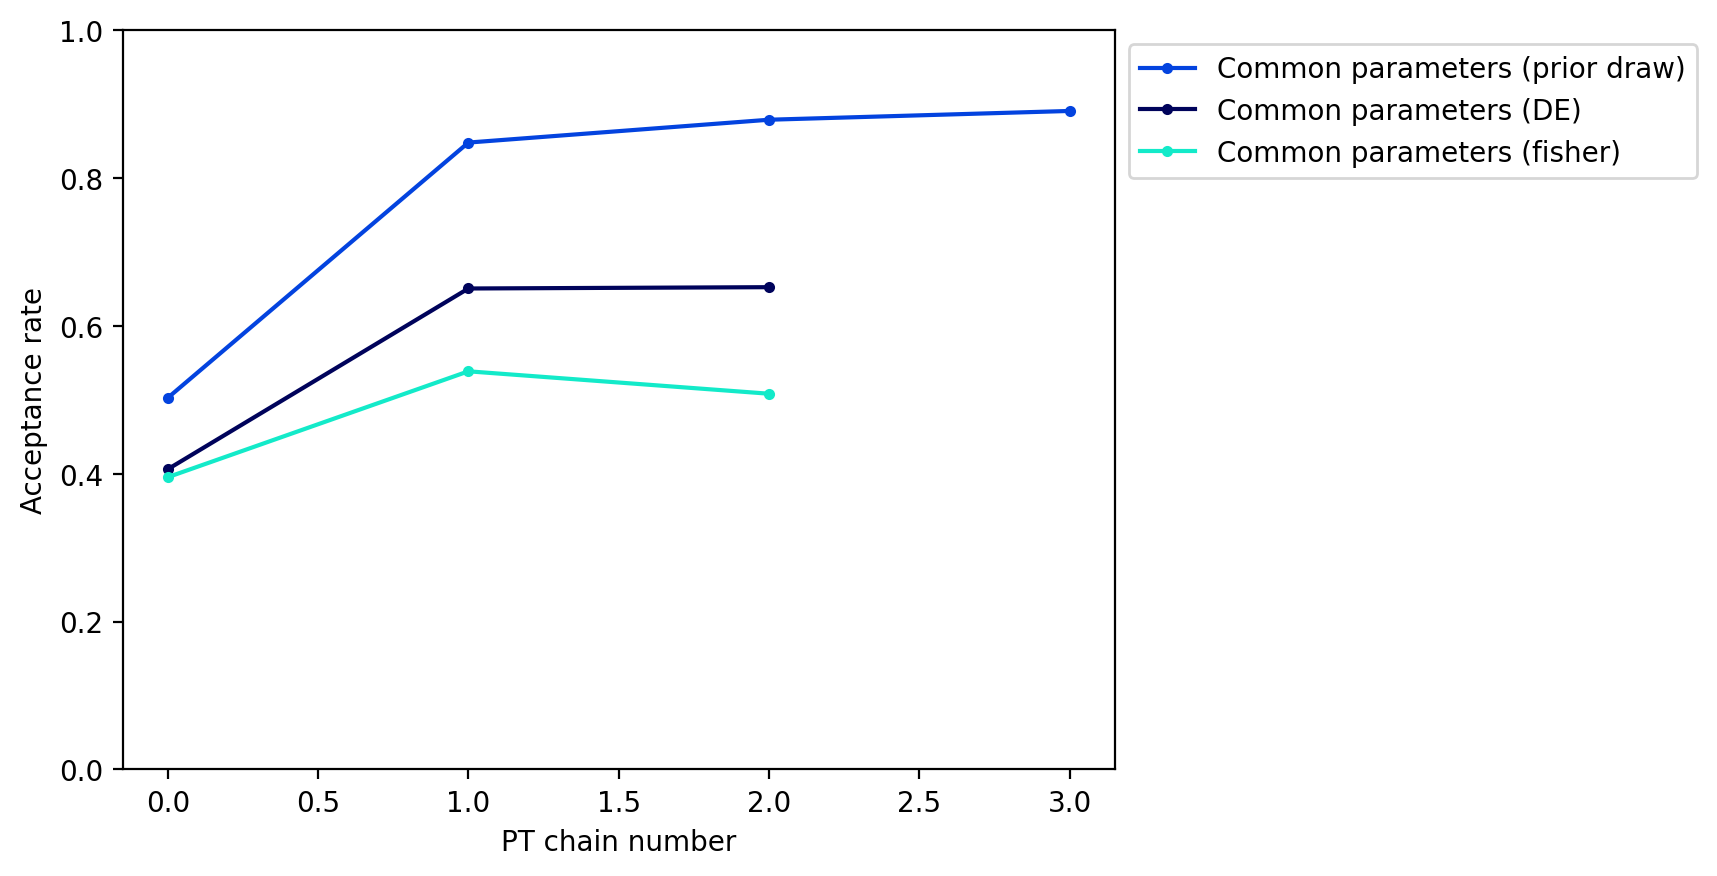

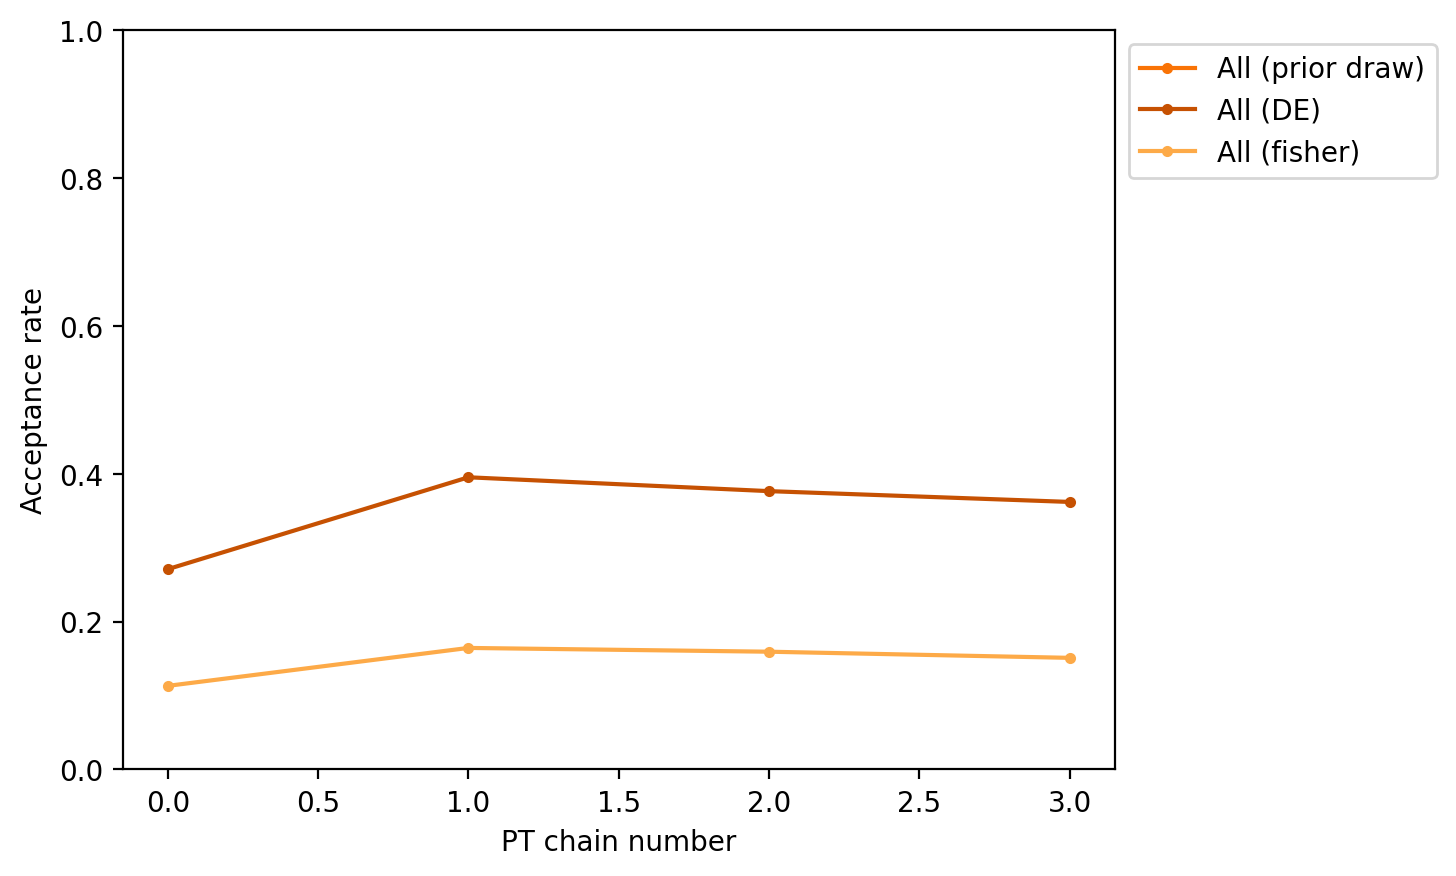

In [9]:
#Plot acceptance fraction for different kinds of steps as a function of PT chain - good for checking is run is okay

plt.figure(0)
plt.plot(acc_fraction[-2,:], color='xkcd:grey', ls='-', marker='.', label="PT")
plt.plot(acc_fraction[-1,:], color='xkcd:blue', ls='-', marker='.', label="Projection parameters")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("PT chain number")
plt.ylabel("Acceptance rate")


plt.figure(1)
plt.plot(acc_fraction[1,:], color='xkcd:green', ls='-', marker='.', label="PSR distance (prior draw)")
plt.plot(acc_fraction[3,:], color='xkcd:light green', ls='-', marker='.', label="PSR distance (DE)")
plt.plot(acc_fraction[5,:], color='xkcd:olive', ls='-', marker='.', label="PSR distance (fisher)")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("PT chain number")
plt.ylabel("Acceptance rate")


plt.figure(2)
plt.plot(acc_fraction[7,:], color='xkcd:dark red', ls='-', marker='.', label="RN (empirical distribution)")
plt.plot(acc_fraction[9,:], color='xkcd:red', ls='-', marker='.', label="RN (DE)")
plt.plot(acc_fraction[11,:], color='xkcd:pink', ls='-', marker='.', label="RN (fisher)")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("PT chain number")
plt.ylabel("Acceptance rate")


plt.figure(3)
plt.plot(acc_fraction[13,:], color='xkcd:purple', ls='-', marker='.', label="GWB (prior draw)")
plt.plot(acc_fraction[15,:], color='xkcd:dark purple', ls='-', marker='.', label="GWB (DE)")
plt.plot(acc_fraction[17,:], color='xkcd:light purple', ls='-', marker='.', label="GWB (fisher)")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("PT chain number")
plt.ylabel("Acceptance rate")

plt.figure(4)
plt.plot(acc_fraction[19,:], color='xkcd:blue', ls='-', marker='.', label="Common parameters (prior draw)")
plt.plot(acc_fraction[21,:], color='xkcd:dark blue', ls='-', marker='.', label="Common parameters (DE)")
plt.plot(acc_fraction[23,:], color='xkcd:aqua', ls='-', marker='.', label="Common parameters (fisher)")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("PT chain number")
plt.ylabel("Acceptance rate")

plt.figure(5)
plt.plot(acc_fraction[25,:], color='xkcd:orange', ls='-', marker='.', label="All (prior draw)")
plt.plot(acc_fraction[27,:], color='xkcd:dark orange', ls='-', marker='.', label="All (DE)")
plt.plot(acc_fraction[29,:], color='xkcd:light orange', ls='-', marker='.', label="All (fisher)")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("PT chain number")
plt.ylabel("Acceptance rate")

100000000
70000000


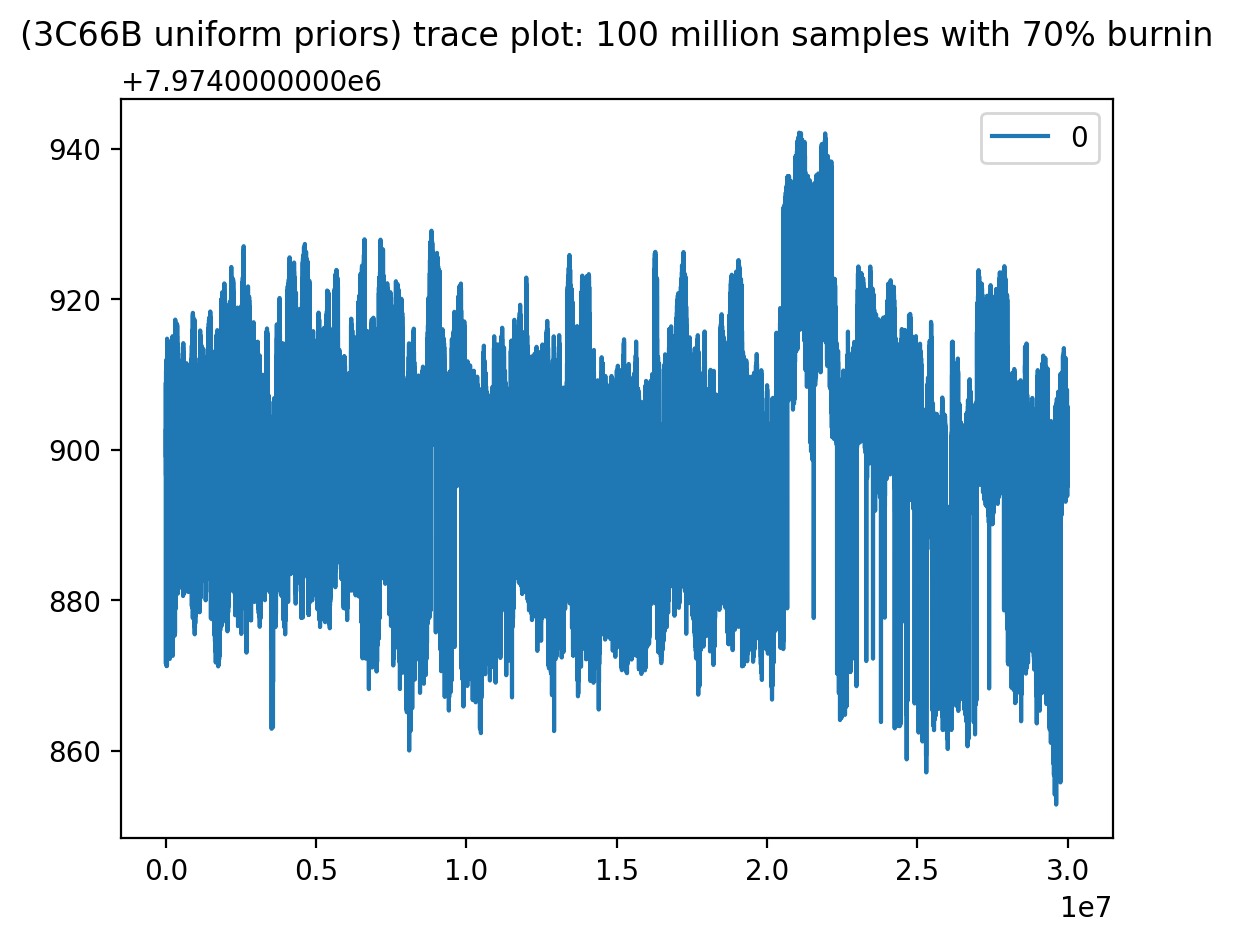

In [10]:
#plot the trace of the likelihood values to see if its sensible
print(log_likelihood.shape[1])
burn = int(0.7*log_likelihood.shape[1])
print(burn)
for j in range(1):
    plt.plot(log_likelihood[j,burn::], label=str(j))
    plt.title('(3C66B uniform priors) trace plot: 100 million samples with 70% burnin', y = 1.05)
plt.legend()

(1e-07, 0.1)

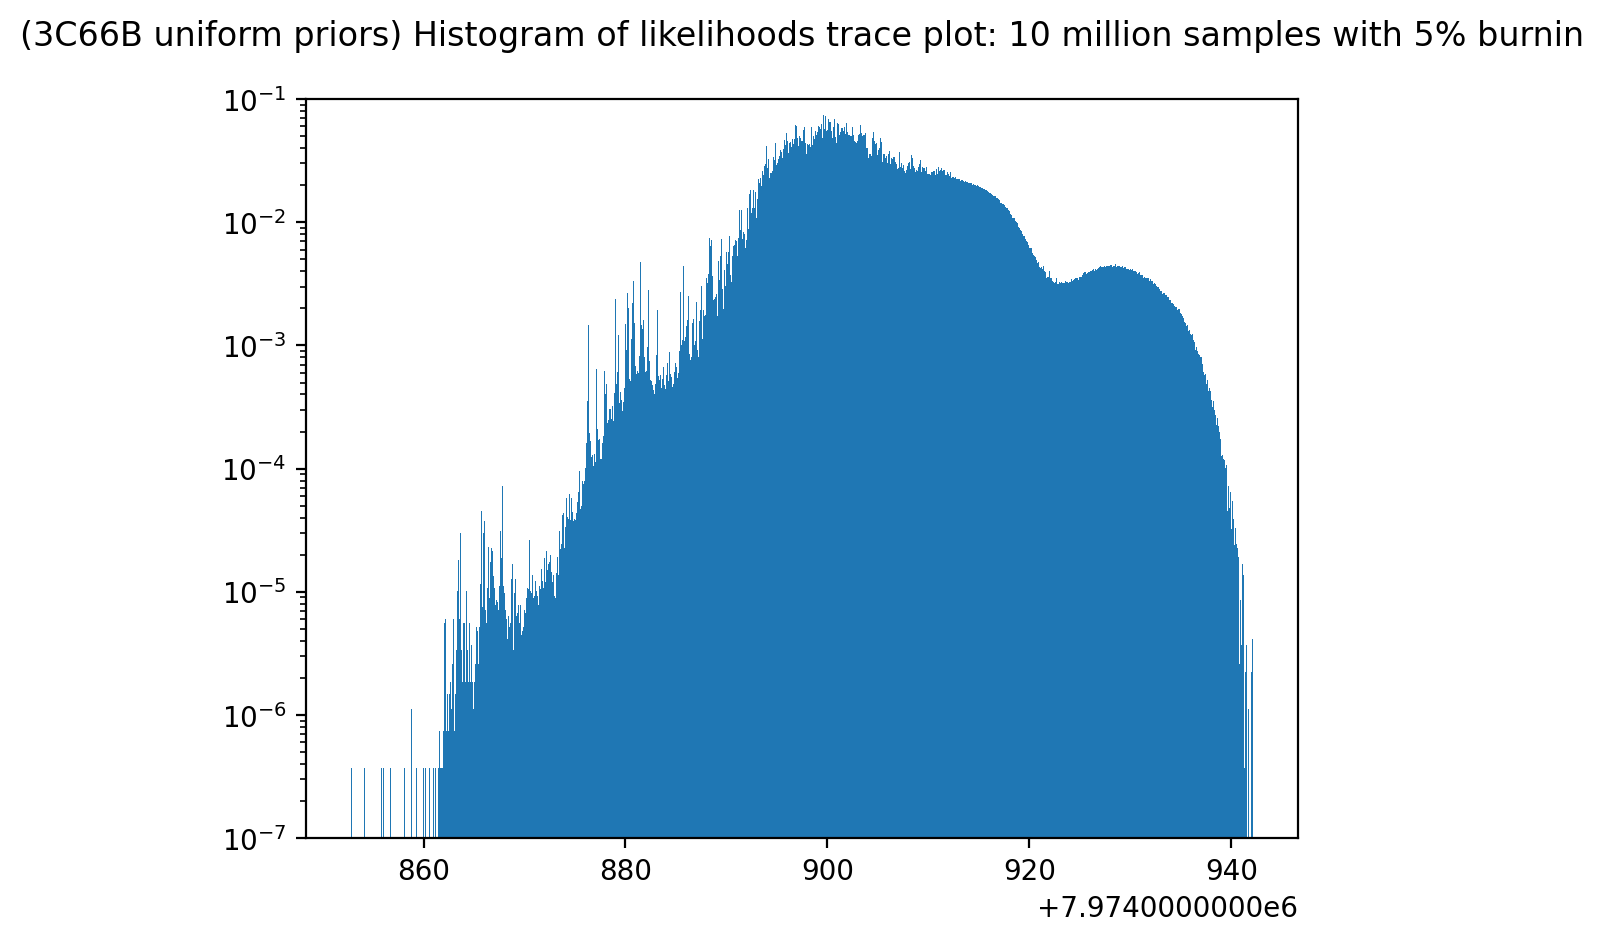

In [11]:
#also plot the histogram of likelihoods
_ = plt.hist(log_likelihood[0,burn::1], density=True, bins=1000)
plt.yscale('log')
plt.title('(3C66B uniform priors) Histogram of likelihoods trace plot: 10 million samples with 5% burnin', y = 1.05)
#plt.xlim(3_302_770, 3_302_860)
plt.ylim(1e-7,1e-1)

In [12]:
#set up dictionary with true values of parameters
#set it to nan where not known

KPC2S = sc.parsec / sc.c * 1e3
SOLAR2S = sc.G / sc.c ** 3 * 1.98855e30

xxx = {"0_cos_gwtheta":np.nan,
       "0_cos_inc":np.nan,
       "0_gwphi":np.nan,
       "0_log10_fgw":np.nan,
       "0_log10_h":np.nan,
       "0_log10_mc":np.nan,
       "0_phase0":np.nan,
       "0_psi":np.nan}

singwtheta = np.sin(np.arccos(xxx['0_cos_gwtheta']))
cosgwtheta = xxx['0_cos_gwtheta']
singwphi = np.sin(xxx["0_gwphi"])
cosgwphi = np.cos(xxx["0_gwphi"])
omhat = np.array([-singwtheta * cosgwphi, -singwtheta * singwphi, -cosgwtheta])

with open('/scratch/na00078/15yr_data/15yr_v1_1/v1p1_all_dict.json', 'r') as fp:
        noisedict = json.load(fp)

for j in range(len(psrs)):
    xxx[psrs[j].name+"_red_noise_gamma"] = noisedict[psrs[j].name+"_red_noise_gamma"]
    xxx[psrs[j].name+"_red_noise_log10_A"] = noisedict[psrs[j].name+"_red_noise_log10_A"]
    xxx[psrs[j].name+"_cw0_p_dist"] = 0.0
    
    #ptheta = psrs[j].theta
    #pphi = psrs[j].phi
    #
    #phat = np.array([np.sin(ptheta) * np.cos(pphi), np.sin(ptheta) * np.sin(pphi), np.cos(ptheta)])
    #cosMu = -np.dot(omhat, phat)
    #
    #pphase = (1 + 256/5 * (10**xxx['0_log10_mc']*SOLAR2S)**(5/3) * (np.pi * 10**xxx['0_log10_fgw'])**(8/3)
    #          * psrs[j].pdist[0]*KPC2S*(1-cosMu)) ** (5/8) - 1
    #pphase /= 32 * (10**xxx['0_log10_mc']*SOLAR2S)**(5/3) * (np.pi * 10**xxx['0_log10_fgw'])**(5/3)
    #
    #xxx[psrs[j].name+"_cw0_p_phase"] = -pphase%(2*np.pi)  
    xxx[psrs[j].name+"_cw0_p_phase"] = np.nan
    
xxx['gwb_gamma'] = np.nan    
xxx['gwb_log10_A'] = np.nan
    
print(xxx)

{'0_cos_gwtheta': nan, '0_cos_inc': nan, '0_gwphi': nan, '0_log10_fgw': nan, '0_log10_h': nan, '0_log10_mc': nan, '0_phase0': nan, '0_psi': nan, 'B1855+09_red_noise_gamma': 3.8866806405154866, 'B1855+09_red_noise_log10_A': -13.938023943317408, 'B1855+09_cw0_p_dist': 0.0, 'B1855+09_cw0_p_phase': nan, 'B1937+21_red_noise_gamma': 4.551004266758053, 'B1937+21_red_noise_log10_A': -13.69093024601203, 'B1937+21_cw0_p_dist': 0.0, 'B1937+21_cw0_p_phase': nan, 'B1953+29_red_noise_gamma': 2.793077624043318, 'B1953+29_red_noise_log10_A': -13.004421069091189, 'B1953+29_cw0_p_dist': 0.0, 'B1953+29_cw0_p_phase': nan, 'J0023+0923_red_noise_gamma': 0.4582094332106858, 'J0023+0923_red_noise_log10_A': -13.298758385319621, 'J0023+0923_cw0_p_dist': 0.0, 'J0023+0923_cw0_p_phase': nan, 'J0030+0451_red_noise_gamma': 4.009012812150594, 'J0030+0451_red_noise_log10_A': -14.202025126236615, 'J0030+0451_cw0_p_dist': 0.0, 'J0030+0451_cw0_p_phase': nan, 'J0340+4130_red_noise_gamma': 1.9786872033091054, 'J0340+4130_r

## Parameter traces and corner plots

In [13]:


#get autocorrelation lengths
#burnin = 0
#burnin = 50_000
#thin = 10

ccs = np.zeros(8)
print(ccs.shape)

for i, par in enumerate(par_names[:8]):
    
    #ccs[i] = emcee.autocorr.integrated_time(samples_cold[burnin::thin,i], c=10, quiet=True)
    ccs[i] = emcee.autocorr.integrated_time(samples_cold[0][...,i], c=10, quiet=True)
    print(par, str(ccs[i]))


(8,)
0_cos_gwtheta 1.0
0_cos_inc 90955.63329643596
0_gwphi 1.0
0_log10_fgw 517838.8589858098
0_log10_h 576876.1465273277
0_log10_mc 684814.765274003
0_phase0 596.1701050688428
0_psi 825.1742050049336


-69999999
0_log10_mc 684814.765274003
0_log10_h 576876.1465273277
0_log10_fgw 517838.8589858098
0_cos_inc 90955.63329643596
0_psi 825.1742050049336
0_phase0 596.1701050688428
0_gwphi 1.0
0_cos_gwtheta 1.0


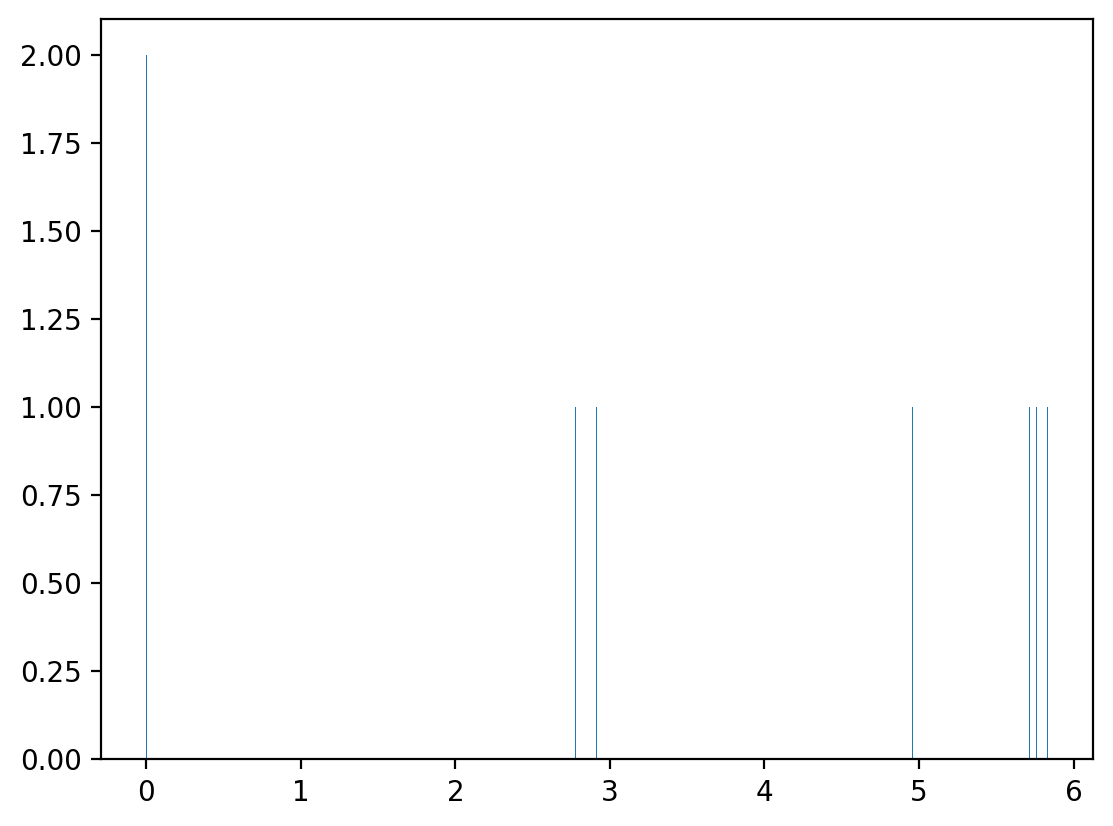

In [14]:

_ = plt.hist(np.log10(ccs), bins=1000)
print(samples_cold.shape[0]-burn)
sort_idx = np.argsort(ccs)
for idx in sort_idx[:-30:-1]:
    print(par_names[idx], str(ccs[idx]))


In [15]:
print(par_names[:15])
print(samples_cold[0].shape)

['0_cos_gwtheta', '0_cos_inc', '0_gwphi', '0_log10_fgw', '0_log10_h', '0_log10_mc', '0_phase0', '0_psi', 'B1855+09_cw0_p_dist', 'B1855+09_cw0_p_phase', 'B1855+09_red_noise_gamma', 'B1855+09_red_noise_log10_A', 'B1937+21_cw0_p_dist', 'B1937+21_cw0_p_phase', 'B1937+21_red_noise_gamma']
(100000000, 8)


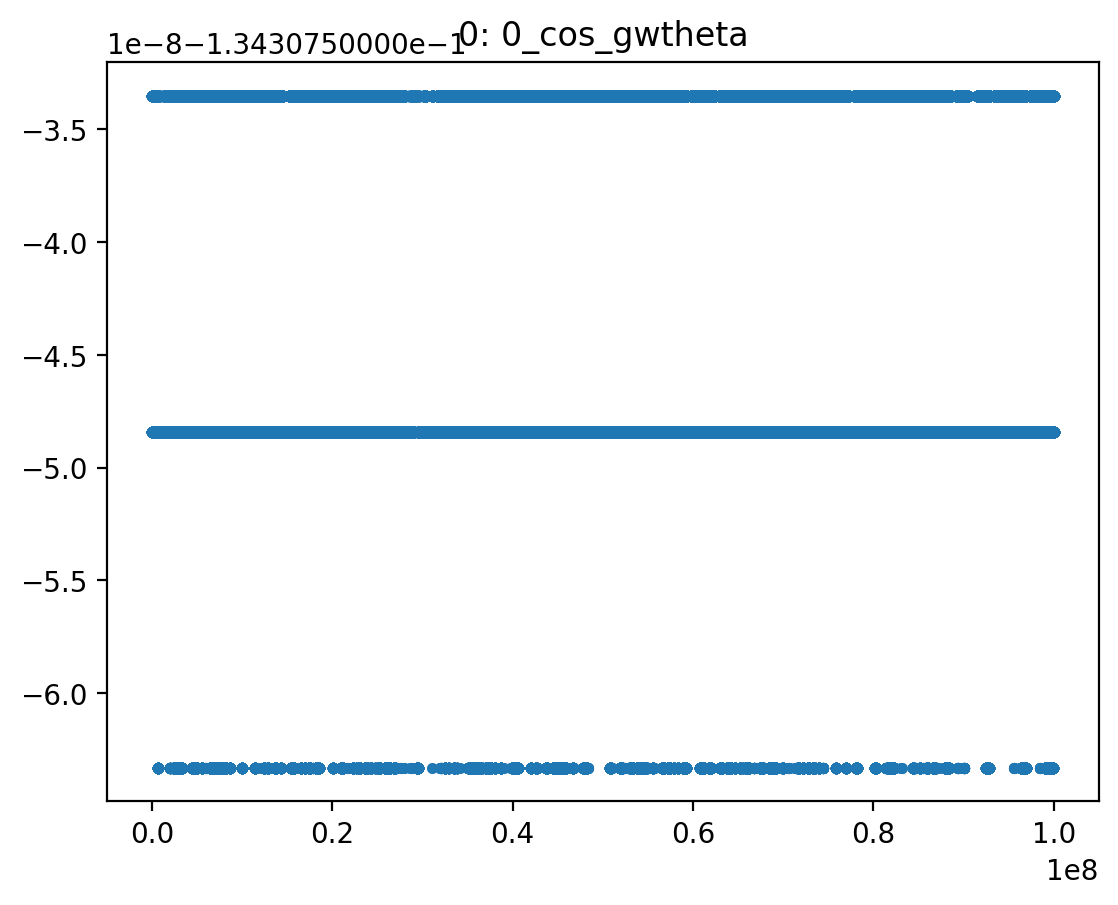

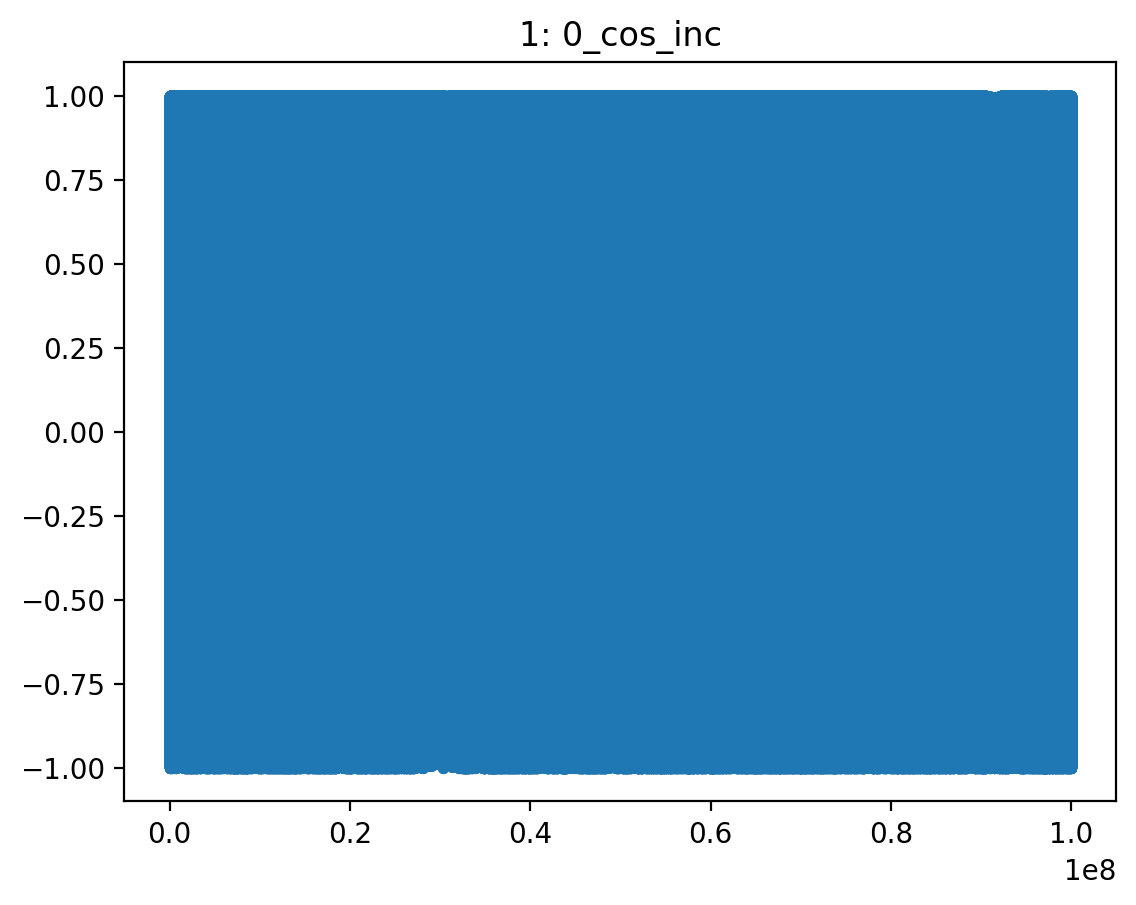

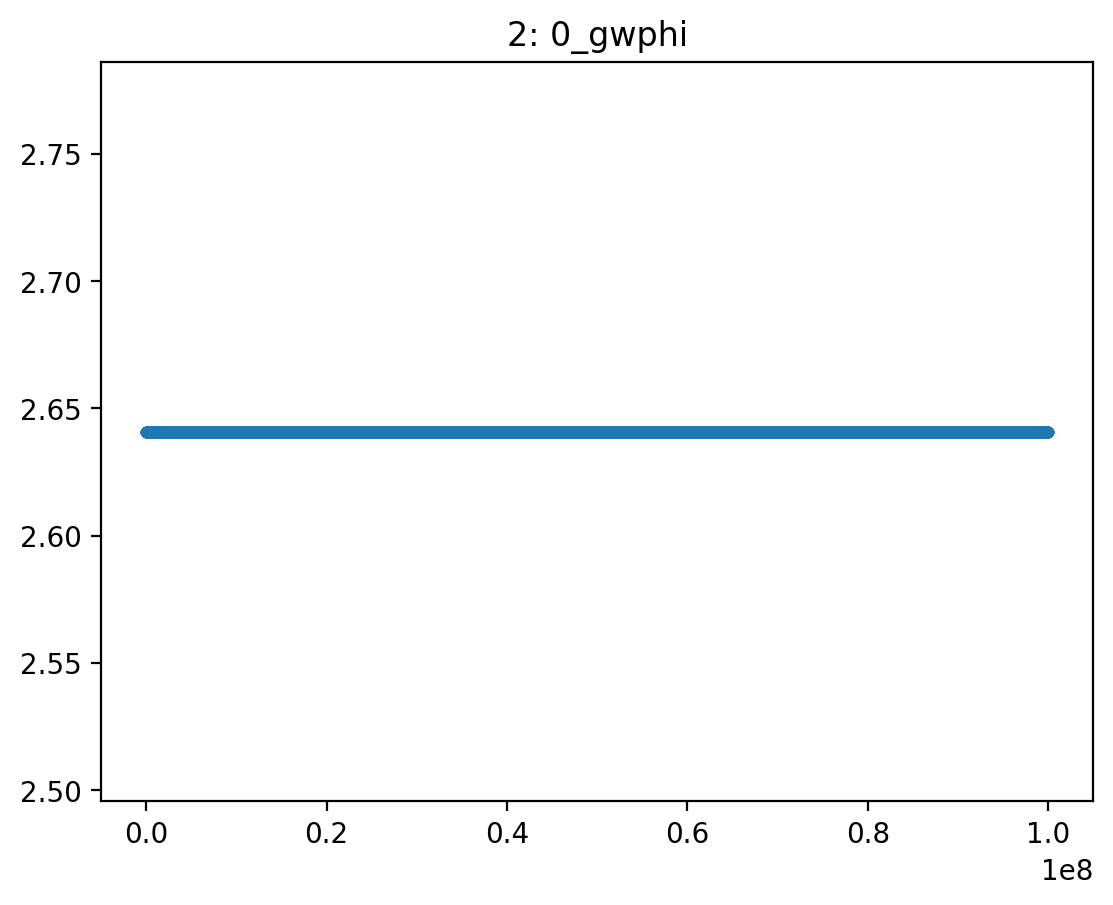

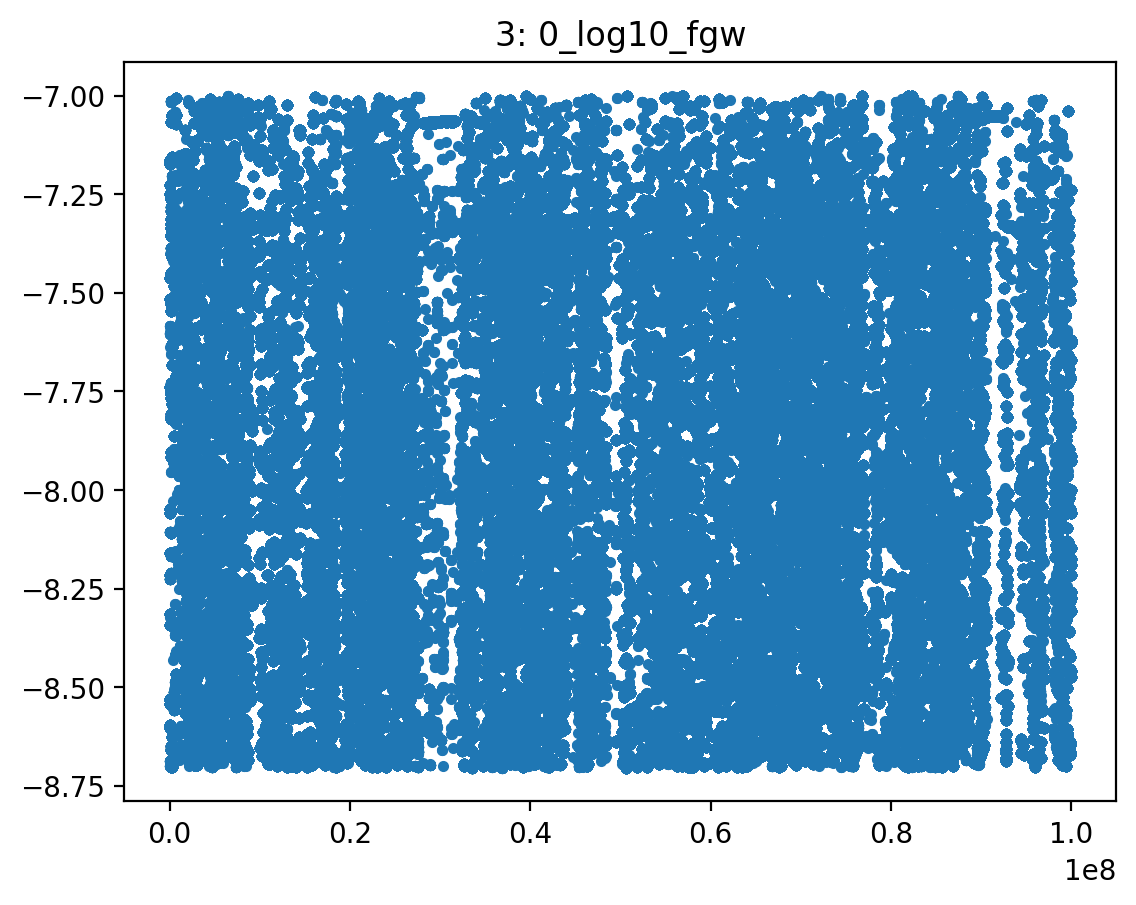

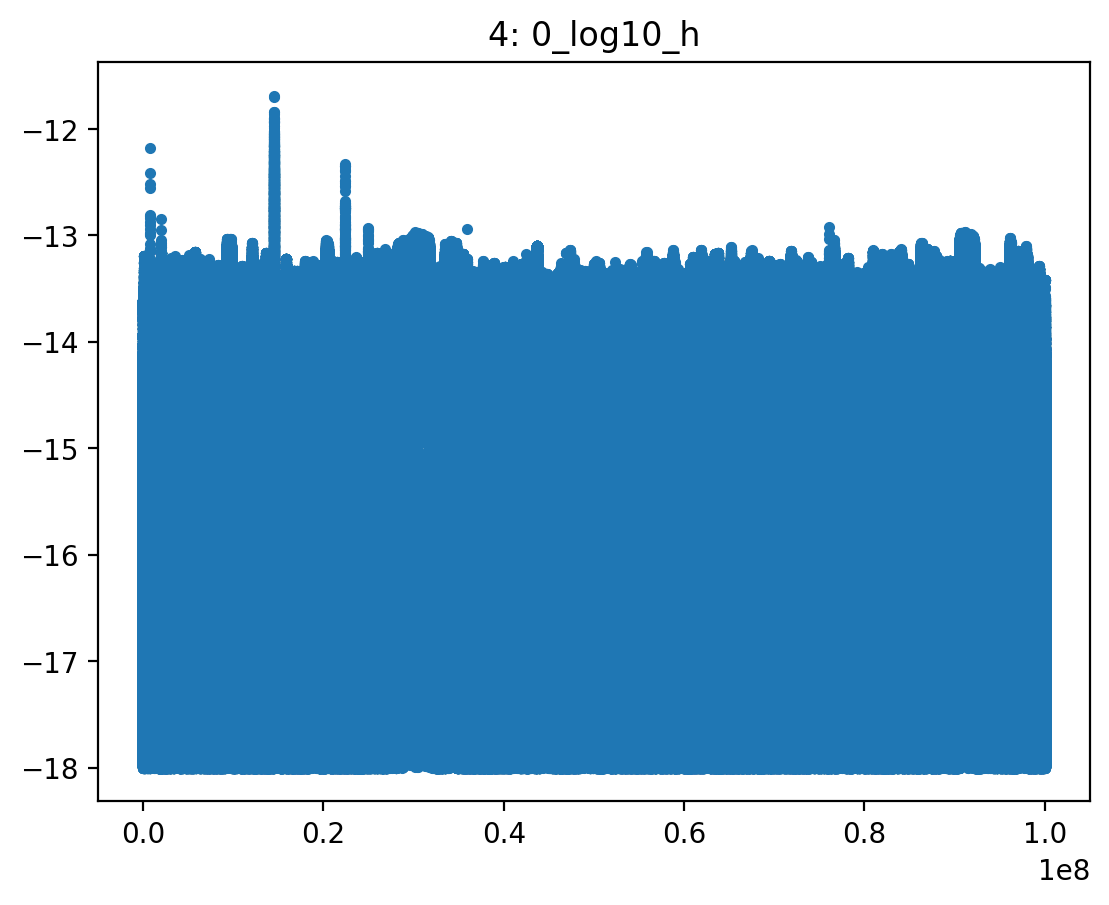

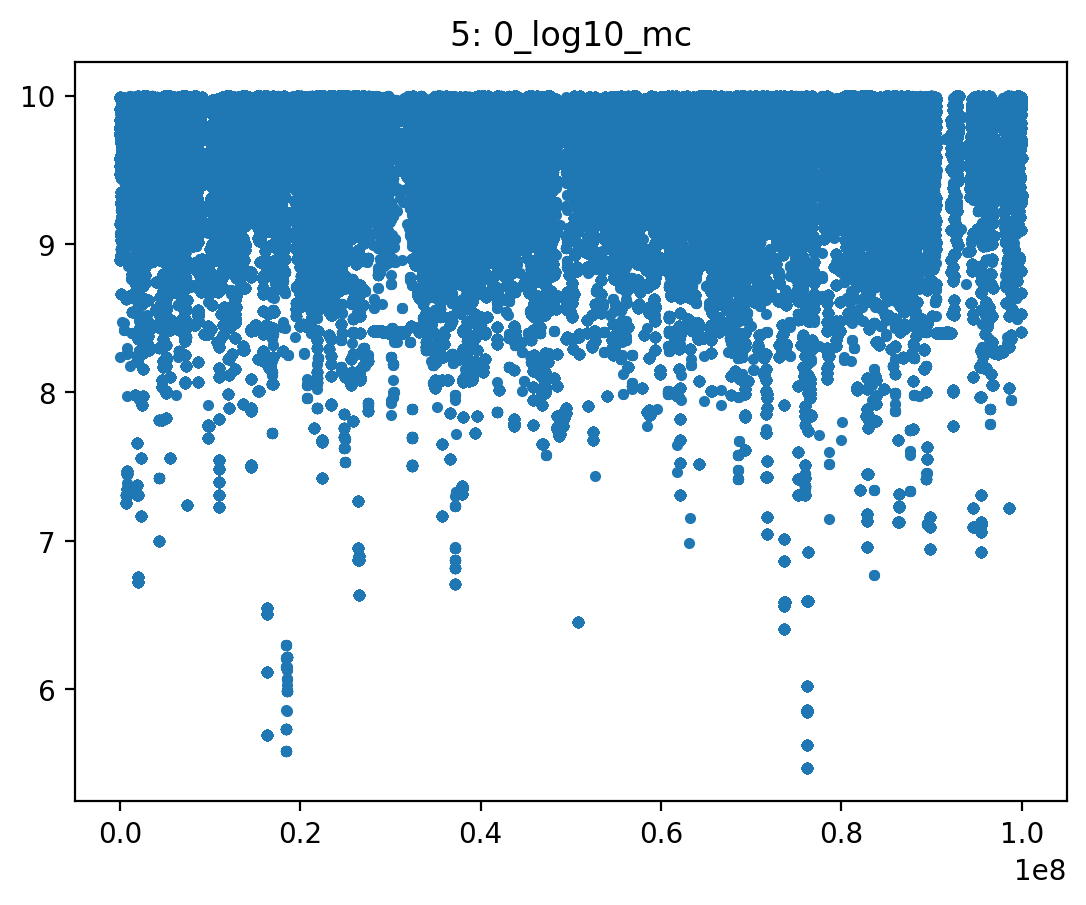

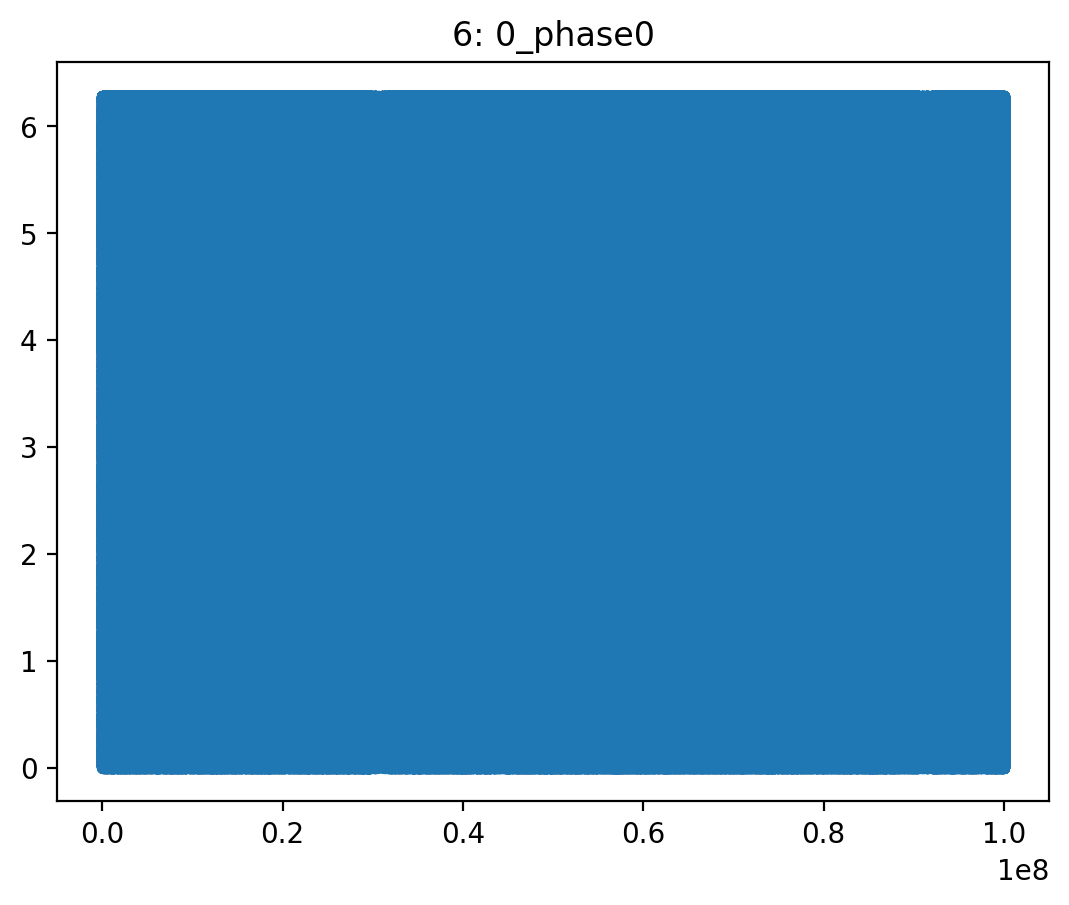

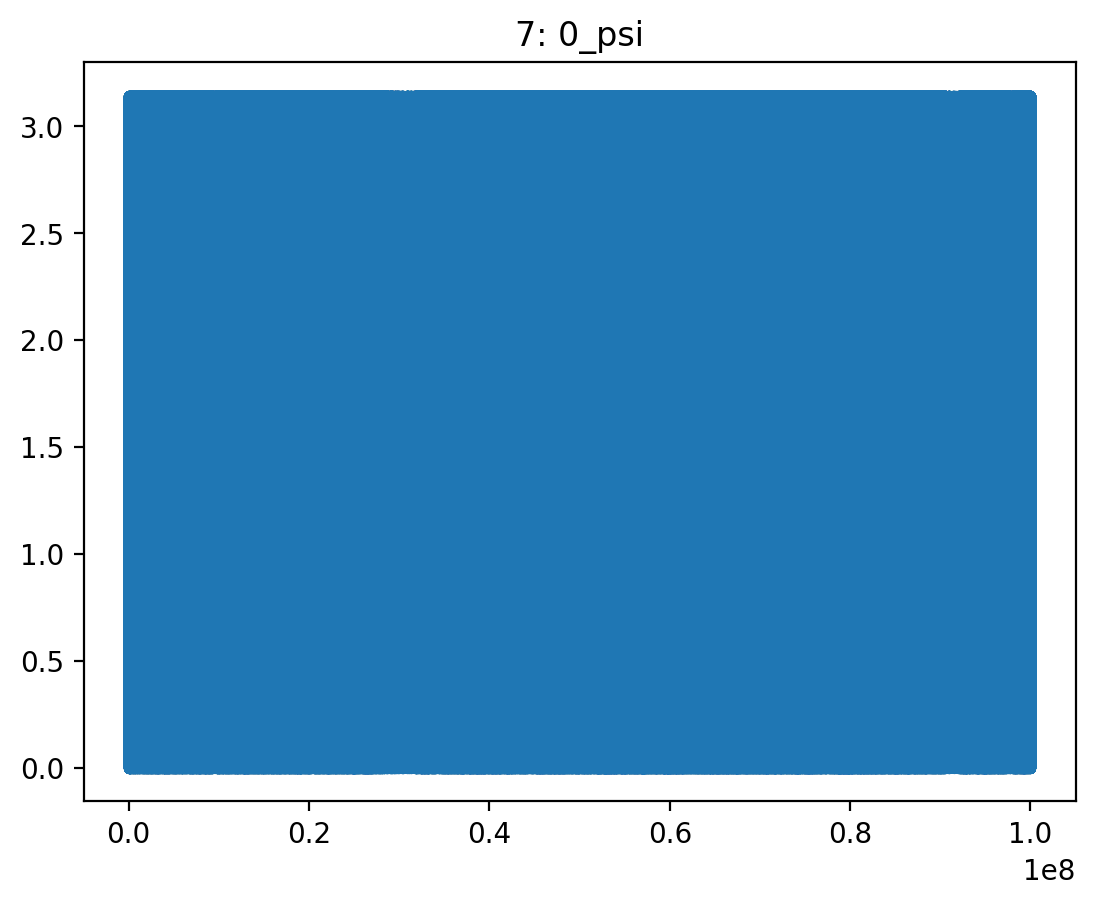

In [16]:
#plot trace of all parameters
for i, par in enumerate(par_names[:8]):
    plt.figure(i)
    plt.plot(samples_cold[0][::,i], ls='', marker='.')
    plt.gca().axhline(xxx[par], ls='--')

    plt.title(str(i) + ": " + par)

In [ ]:
value=np.linspace(-9, -7.5)
mu=np.log10(1.13e-8)
sigma=1
test = np.exp(-0.5 * (value - mu) ** 2 / sigma**2) / np.sqrt(2 * np.pi * sigma**2)
print(test.shape)

In [ ]:
import scipy.stats as stats
def plot_Gaussian(xrange,mu, sigma):
    X_linSpace = xrange
    Y_norm_PDF = stats.norm.pdf(xrange, mu, sigma)
    return Y_norm_PDF

Xs = np.linspace(-9, -7.5)
Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
plt.plot(Xs,Y)
plt.show()

In [ ]:
#corner plot of parameters common to all pulsars UNIFORM PRIOR

corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"${\cal M}$", r"$\Phi_0$", r"$\psi$"]


#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (np.log10(3.5e-9),-7), (-18,-11), (10**7,10**10), (0,2*np.pi), (0,np.pi) ]

#set burnin and thinning
burnin = 10000000
thin = 1000

truth = [xxx[key] for key in par_keys]
samples_cold_UL = np.vstack((samples_cold[0][burnin::thin,0],
                          samples_cold[0][burnin::thin,1],
                          samples_cold[0][burnin::thin,2],
                          samples_cold[0][burnin::thin,3],
                          samples_cold[0][burnin::thin,4],
                          10**samples_cold[0][burnin::thin,5],
                          samples_cold[0][burnin::thin,6],
                          samples_cold[0][burnin::thin,7])).T

fig = corner.corner(samples_cold_UL,
                    labels=labels,
                    show_titles=True, range=ranges, hist_kwargs={"density":True}) #quantiles=[0.16, 0.5, 0.84],

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('NGC3115_targetedfreq_upper_limit_without_dL', fontsize = 25);

In [ ]:
#corner plot of parameters common to all pulsars UNIFORM PRIOR

corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$"]


#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (np.log10(3.5e-9),-7), (-18,-11), (7,10), (0,2*np.pi), (0,np.pi) ]

#set burnin and thinning
burnin = 10000000
thin = 1000

val=[]
truth = [xxx[key] for key in par_keys]
'''
for j in corner_mask:
    print(j)
    if j==4:
        x = np.power(10,samples_cold[0][burnin::thin,j])
    else:
        x = samples_cold[0][burnin::thin,j]
        val.append(x)
print(np.shape(val))
print(np.shape(samples_cold[0][burnin::thin,corner_mask]))
        
fig = corner.corner(val, labels=labels, show_titles=True, # quantiles=[0.16, 0.5, 0.84],
                    truths=truth, range=ranges, hist_kwargs={"density":True})
'''
    
#fig = corner.corner(samples_cold[0][burnin::thin,corner_mask], labels=labels, show_titles=True, # quantiles=[0.16, 0.5, 0.84],
 #                   truths=truth, range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    #print(i,fig.axes)
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        ax.plot(Xs, Xs*0+1/(-7-np.log10(3.5e-9)), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green") 
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 10)
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('3C66B_targetedfreq_detection', fontsize = 25);
        

In [ ]:
M_sun = 1.989e+30
logMcmin_dL = np.min(samples_cold[0][::10,5])
logMcmax_dL = np.max(samples_cold[0][::10,5])
#print(logAmin_dL)
#print(len(samples2plot[d_L_mask,4]))

plt.hist(np.power(10,samples_cold[0][::10,5]), bins=20, density=True,color='green')
plt.axvline(x = 6374879232.0,color="red")
#plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')
plt.title("NGC3115 Upper Limit Mc histogram (without dL masking)", y=1.05)
plt.xlabel("Mc")
plt.ylabel("Posterior")
plt.show()

In [ ]:
x = np.quantile(np.power(10,samples_cold[0][::10,5]), 0.95)
print(x)
print(np.log10(x))

In [ ]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
# corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
corner_mask = [1, 2,3,4, 5, 6,7]

par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]

#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = 10000000
thin = 1

#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-17.3,-11), (7,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
#####################################
target_d_L = 93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print(d_L_min)
print(d_L_max)
print(10**log10_d_L)
print(np.min(10**log10_d_L))
print(np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>d_L_min) & (10**log10_d_L<d_L_max))[0]


samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print(samples2plot.shape)
print(len(d_L_mask))
print(len(ranges))
fig = corner.corner(samples2plot[d_L_mask, :],
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=None, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_detection_dL_93.6_Correlated', fontsize = 25);

In [ ]:
#corner plot of parameters common to all pulsars UNIFORM PRIOR

corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$"]


#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (np.log10(3.5e-9),-7), (-18,-11), (7,12), (0,2*np.pi), (0,np.pi) ]

#set burnin and thinning
burnin = 10000000
thin = 1000

truth = [xxx[key] for key in par_keys]
fig = corner.corner(samples_cold[0][burnin::thin,corner_mask], labels=labels, show_titles=True, # quantiles=[0.16, 0.5, 0.84],
                    truths=truth, range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        ax.plot(Xs, Xs*0+1/(-7-np.log10(3.5e-9)), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('3C66B_targetedfreq_detection', fontsize = 25);

In [ ]:
#corner plot of parameters common to all pulsars NORMAL PRIOR
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$"]


#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (np.log10(3.5e-9),-7), (-18,-11), (7,12), (0,2*np.pi), (0,np.pi) ]

#set burnin and thinning
burnin = 1000000
thin = 1000

print(len(ranges))
print(samples_cold.shape)

truth = [xxx[key] for key in par_keys]
fig = corner.corner(samples_cold[0][burnin::thin,corner_mask], labels=labels, show_titles=True, # quantiles=[0.16, 0.5, 0.84],
                    truths=truth, range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw 
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        ax.plot(Xs,Y, color='xkcd:green')
       
        # ax.plot(Xs, Xs*0+1/(-7-np.log10(3.5e-9)), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        Y=plot_Gaussian(Xs,9.86,1)
        ax.plot(Xs,Y, color='xkcd:green')
        #
        # ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('3C66B_targetedfreq_detection', fontsize = 25);

In [ ]:
#corner plot of parameters common to all pulsars
corner_mask = [0, 1, 2, 3, 4]
par_keys = [ "0_cos_inc", "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]
labels = [r"$\cos \iota$", r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$"]


#set ranges
ranges = [ (-1,1), (-18,-11), (7,10), (0,2*np.pi), (0,np.pi) ]

#set burnin and thinning
burnin = 100
thin = 10

truth = [xxx[key] for key in par_keys]
fig = corner.corner(samples_cold[burnin::thin,corner_mask], labels=labels, #show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    truths=truth, range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0: #cos inc 
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==3: #phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==1: #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==2: #log10_M_ch
        Xs = np.linspace(7, 10)
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==4: #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_NGC3115_1billion_targetedfreq_detection', fontsize = 25);

In [ ]:
#corner plots for pulsar specific parameters

for I, psr in enumerate(psrs[:]):
    plt.figure(I)
    print(psr.name)
    corner_mask = [8+I*4, 9+I*4, 10+I*4, 11+I*4]
    labels = ["{0}_cw0_p_dist".format(psr.name), "{0}_cw0_p_phase".format(psr.name),
              "{0}_red_noise_gamma".format(psr.name), "{0}_red_noise_log10_A".format(psr.name)]
    #ranges = [(-3,3), (0, 2*np.pi), 0.999, 0.999]
    ranges = [(-3,3), (0, np.pi), (0,7), (-20,-11)]

    burnin = 100
    thin = 10

    truth = [xxx[key] for key in labels]
    fig = corner.corner(samples_cold[burnin::thin,corner_mask], labels=labels,
                        truths=truth, range=ranges, hist_kwargs={"density":True})

    Xs = np.linspace(0,2*np.pi)
    Ys = np.linspace(-3.0,3.0)
    Zs = np.linspace(0.0,7.0)
    Qs = np.linspace(-20.0, -11.0)

    for i, ax in enumerate(fig.axes):
        if i%(len(labels)+1)==0:
            if i%(4*(len(labels)+1))==0: #psr distance
                ax.plot(Ys, norm.pdf(Ys), color="xkcd:green")
            elif i%(4*(len(labels)+1))==1*(len(labels)+1): #psr phase
                ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
            elif i%(4*(len(labels)+1))==2*(len(labels)+1): #rn gamma
                ax.plot(Zs, Zs*0+1/7.0, color="xkcd:green")
            elif i%(4*(len(labels)+1))==3*(len(labels)+1): #rn log_10_A
                ax.plot(Qs, Qs*0+1/9.0, color="xkcd:green")
        #print(ax.set_xlabel(i))

In [ ]:
#gwb
corner_mask = [-2, -1]
labels = ["gwb_gamma", "gwb_log10_A"]
#ranges = [0.999, ]*8
ranges = [(0,7), (-20,-11)]

#burnin = 0
#burnin = 50_000
burnin = 100_000
thin = 10

truth = [xxx[key] for key in labels]
fig = corner.corner(samples_cold[burnin::thin,corner_mask], labels=labels,
                    truths=truth, range=ranges, hist_kwargs={"density":True})

# SD BF

In [ ]:
logAmin_dL = np.min(samples2plot[d_L_mask,4])
logAmax_dL = np.max(samples2plot[d_L_mask,4])
print(logAmin_dL)
print(len(samples2plot[d_L_mask,4]))

plt.hist(samples2plot[d_L_mask,4], bins=20, density=True)
plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')
plt.show()

In [ ]:
#d_L correlated SD BF
logamins = np.linspace(logAmin_dL, -15, 100)
BF_arr = []
BF_err_arr = []

from enterprise_extensions import model_utils
for logamin in logamins:
    BF,BF_err = model_utils.bayes_fac(samples = samples2plot[d_L_mask,4], logAmin=logamin, logAmax=-11)
    BF_arr.append(BF)
    BF_err_arr.append(BF_err)

plt.errorbar(logamins, BF_arr, yerr=BF_err_arr, fmt='o')
plt.show()

In [ ]:
print(BF_err_arr[0:10])

In [ ]:
#Non d_L correlated SD BF
from enterprise_extensions import model_utils
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)

In [ ]:
#All wrong
from enterprise_extensions import model_utils
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-14.6)
print('log10A BF = ', BF, " +- ", BF_err)

MCBF,MCBF_err =model_utils.bayes_fac(samples = samples_cold[0][::10,5], logAmin =7.33, logAmax= 8.65)
print('Mc BF = ', MCBF, " +- ", MCBF_err)

freqBF,freqBF_err =model_utils.bayes_fac(samples = samples_cold[0][::10,3], logAmin = -7.25 ,logAmax=-7.2)
print('freq BF = ', freqBF, " +- ", freqBF_err)

In [ ]:
f_min = 1e-9
f_max = 3e-7
print(f_min, f_max)

n_bins = 45#20#50

fbins = np.linspace(np.log10(f_min), np.log10(f_max), n_bins+1)
print(10**fbins[11], 10**fbins[12])

#set burnin and thinning
#burnin = 10_000
burnin = 100_000
thin = 1

log10_f = samples_cold[0][burnin::thin,3]
log10_A = samples_cold[0][burnin::thin,4]

"""n_bins = 50
#fmin = 10**(-8.704)
#fmax = 10**(-7.6)
fmin = -8.704
fmax = -7.6
fbins = np.linspace(fmin, fmax, n_bins+1)
print(fbins)
BFs = np.zeros(n_bins)"""

n_h_bin = 50
n_h_bin4err = 10
bins = np.linspace(-18,-11, n_h_bin)
#bins = np.linspace(-18,-11, 20)
prior_dens = 1/7.0

matplotlib.rcParams.update({'font.size': 12})

BFs = np.zeros(n_bins)
BF_errs = np.zeros(n_bins)
for i in range(n_bins):
    #f_mask = np.where((10**log10_f>fbins[i]) & (10**log10_f<fbins[i+1]))
    f_mask = np.where((log10_f>fbins[i]) & (log10_f<fbins[i+1]))
    hist = plt.hist(log10_A[f_mask], bins=bins, histtype='step', density=True,
                   color='xkcd:black', alpha=0.0)
    BFs[i] = prior_dens/hist[0][0]
    
    #h_autocorr = emcee.autocorr.integrated_time(log10_A[f_mask], c=10, quiet=True)
    #N_eff = np.where((log10_A[f_mask]>bins[0]) &  (log10_A[f_mask]<bins[1]))[0].size/h_autocorr
    #N_eff = log10_A[f_mask].size/h_autocorr
    #N_eff = np.where((log10_A[f_mask]>bins[0]) &  (log10_A[f_mask]<bins[1]))[0].size
    #print(h_autocorr, log10_A[f_mask].size, N_eff)
    #BF_errs[i] = BFs[i]/np.sqrt(N_eff)
    
    BF_errs[i] = np.std(prior_dens/hist[0][:n_h_bin4err])
    
    if BFs[i]>250.0 and BFs[i]<np.inf:
        plt.hist(log10_A[f_mask], bins=bins, histtype='step', density=True,
                 label="{0:.2f} nHz - {1:.2f} nHz: BF={2:.1f}".format(10**fbins[i]*1e9,
                                                                      10**fbins[i+1]*1e9,
                                                                      BFs[i]),
                 alpha=1.0)
        plt.gca().axhline(prior_dens/(BFs[i]+BF_errs[i]))
        plt.gca().axhline(prior_dens/(BFs[i]))
        plt.gca().axhline(prior_dens/(BFs[i]-BF_errs[i]))
        



plt.legend(loc=1, bbox_to_anchor=(1,0))
plt.yscale('log')
plt.gca().axhline(prior_dens, ls='--', color='xkcd:green')
    
print(BFs)  

# SkyMap Check

In [ ]:
#Figure 1a of Mingarelli + 2017
import astropy.constants as c
from astropy.coordinates import SkyCoord

RA_ra = np.mean(samples2plot[::,2])
DEC_ra= np.mean(np.pi/2-np.arccos(samples2plot[::,0]))

RA = RA_ra-np.pi
DEC = DEC_ra-np.pi/2

print(RA,DEC)


c = SkyCoord(ra = '16h44m52.7s', dec = '+43d07m52.9s')

RA_expect = c.ra.radian-np.pi
DEC_expect=c.dec.radian-np.pi/2
print(RA_expect,DEC_expect)
ax = plt.subplot(111, projection='mollweide')
ax.grid()
ax.scatter(RA,DEC, edgecolors='none',  alpha=1, rasterized=True, label = 'QuickCW')
ax.plot(RA_expect,DEC_expect, color='m', marker='*',  alpha=1, rasterized=True,markersize=12,label='Direct From Coordinates')
#ax.plot(30,-15)
plt.legend()
plt.suptitle("HS1630 loc param dist",  y=0.15)
#plt.savefig("2MASS_galaxies.pdf")

In [ ]:
import matplotlib.projections as pltProj

pltProj.get_projection_names()

## UL vs. frequency

In [ ]:
official_11yr_skyavg = np.loadtxt("../data/11yr_ul_skyavg_DE436.txt")

In [ ]:
%%time
plt.rcParams.update({'font.size': 18})

#burnin = 100_000
burnin = 50_000
thin=1
#thin = 10*int(np.max([ccs[3],ccs[4]]))
print(thin)

log10_fgws = samples_cold[burnin::thin,3]
log10_hs = samples_cold[burnin::thin,4]
print(log10_fgws.size)


"""f_bincenters = official_11yr_skyavg[1:67,0]
#f_bincenters = official_11yr_skyavg[1:8,0]
print(f_bincenters)
f_bins = []
for i in range(f_bincenters.shape[0]-1):
    f_bins.append(f_bincenters[i]-(f_bincenters[i+1]-f_bincenters[i])/2)
f_bins.append(f_bincenters[-1]-(f_bincenters[-1]-f_bincenters[-2])/2)
f_bins.append(f_bincenters[-1]+(f_bincenters[-1]-f_bincenters[-2])/2)
print(f_bins)"""

f_min = 10**np.min(samples_cold[::10,3])
f_max = 10**np.max(samples_cold[::10,3])
print(f_min, f_max)
#f_bins = np.linspace(f_min, f_max, int(f_max/f_min))
f_bins = np.arange(1,int(f_max/f_min)+1)*f_min
print(f_bins)

f_bincenters = []
for i in range(f_bins.size-1):
    f_bincenters.append((f_bins[i+1]+f_bins[i])/2)
print(f_bincenters)

log10_h_bins = np.linspace(-18,-11,100)

plt.figure(figsize=(8,7))
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=50, range=[[np.log10(3.5e-9),-7],[-18,-11]])
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=100, range=[[np.log10(3.5e-9),-7],[-15.5,-11]],
#                                  weights=log10_fgws*0+1/60.0)
h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=[np.log10(f_bins), log10_h_bins])

#make bin centers
bincenters = []
for i in range(xedges.size-1):
    bincenters.append((xedges[i+1]+xedges[i])/2)
bincenters = np.array(bincenters)

#print(xedges)
#print(bincenters)

freq_idx = np.digitize(log10_fgws, xedges)
#plt.scatter(log10_fgws[np.where(freq_idx==1)], log10_hs[np.where(freq_idx==1)])

N_bootstrap = 1000
#N_resample = 100

UL_freq = np.zeros(bincenters.size)
#UL_freq_reweight = np.zeros(bincenters.size)
#UL_freq_reweight_low = np.zeros(bincenters.size)
#UL_freq_reweight_high = np.zeros(bincenters.size)
UL_freq_error = np.zeros(bincenters.size)
for i in range(bincenters.size):
    print('---')
    print(i)
    hs = 10**log10_hs[np.where(freq_idx==i+1)]
    if hs.size==0:
        UL_freq[i] = 0.0
        continue
    
    UL_freq[i] = np.percentile(hs, 95)

    N_inbin = hs.shape[0]
    N_resample = int(N_inbin)

    print(N_inbin)

    #N_batch = int(N_inbin**(1/5))
    N_batch = 10
    if N_inbin<10*N_batch:
        N_batch=1
    print(N_batch)
    
    hs_batches = []
    for K in range(N_batch):
        hs_batches.append(hs[K*int(N_inbin/N_batch):(K+1)*int(N_inbin/N_batch)])

    ULs = np.zeros(N_bootstrap)
    for k in range(N_bootstrap):
        IDXS = np.random.choice(N_batch, size=N_batch, replace=True)
        hs_shuffle = np.block([hs_batches[J] for J in IDXS])
        ULs[k] = np.percentile(hs_shuffle, 95)
    
    UL_freq_error[i] = np.std(ULs)
    

plt.gca().axvline(x=-np.log10(3600*24*365.24), ls='--', lw=3, color='white', label='1/yr')
plt.gca().axvline(x=-np.log10(3600*24*365.24*0.5), ls=':', lw=3, color='white', label='2/yr')
#plt.plot(bincenters, UL_freq, ls='-', lw=3, marker='.', color="xkcd:red", label="95% UL")
#plt.errorbar(bincenters, np.log10(UL_freq), ls='-', lw=3, marker='x', color="xkcd:red",
#             label="95% UL - this run - old", alpha=0.3)
plt.errorbar(xedges[:-1], np.log10(UL_freq), ls='-', lw=3, color="xkcd:red",
             drawstyle='steps-post', label="95% UL - this run")
#plt.fill_between(bincenters, UL_freq_reweight_low, UL_freq_reweight_high,
#                 color="xkcd:red", alpha=0.3, label="95% UL")
plt.plot(np.log10(official_11yr_skyavg[1:67,0]), np.log10(official_11yr_skyavg[1:67,1]),
         ls='--', lw=3, marker='x', color="xkcd:green", label="95% UL - official 11yr")
#plt.plot(np.log10(official_11yr_skyavg[:,0]), np.log10(official_11yr_skyavg[:,2]),
#         ls='--', lw=3, marker='.', color="xkcd:purple", label="95% UL - official2")
plt.ylim(-15,-11)
#plt.xlim(-8.75, -7.0)
plt.xlabel(r"$\log_{10} f_{\rm GW}$")
plt.ylabel(r"$\log_{10} A_{\rm e}$")

cbar = plt.colorbar(location='top')
cbar.set_label('#')

plt.legend(loc=2)

plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("Figs/UL_vs_freq.png", dpi=300)
#plt.savefig("Figs/UL_vs_freq_new_seed.png", dpi=300)

In [ ]:
plt.figure(figsize=(8,7))

plt.errorbar(10**bincenters, UL_freq, yerr=UL_freq_error,
             ls='', lw=2, marker='.', alpha=0., color="xkcd:red")

plt.errorbar(10**xedges[:-1], UL_freq, drawstyle='steps-post',
             ls='-', lw=2, marker='', alpha=1.0, color="xkcd:red", label="95% UL - this run\n(1-sigma errors)")

plt.errorbar(official_11yr_skyavg[1:67,0], official_11yr_skyavg[1:67,1],
             yerr=official_11yr_skyavg[1:67,2],
             ls='-', lw=2, marker='', color="xkcd:green", label="95% UL - official 11yr\n(1-sigma errors)")

plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-15,4e-12)
plt.xlabel(r"$f_{\rm GW}$")
plt.ylabel(r"$A_{\rm e}$")

plt.legend(loc=2)